In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumnRenamed('winPlaceClass', 'label')


In [3]:
inputCols =  data.columns
toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
inputCols = list(set(inputCols) - set(toRemove))

In [4]:
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [5]:
seed = 12
withReplacement=False
output = output.sample(withReplacement, 0.3, seed).select("features", "label")

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 423703
testing: 181107


In [6]:
training.groupBy('label').count().toPandas()

,label,count
0,1,9936
1,6,10053
2,3,99108
3,5,100676
4,4,104799
5,2,99131


## GridSearch

In [7]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [10, 15]) \
    .addGrid(rf.minInstancesPerNode, [5, 10]) \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.impurity, ['gini','entropy']) \
    .build()


In [8]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4) 

cvModel = crossval.fit(training)

In [9]:
# Best parameters
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='RandomForestClassifier_e4aa6aceda4b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='RandomForestClassifier_e4aa6aceda4b', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 5, Param(parent='RandomForestClassifier_e4aa6aceda4b', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_e4aa6aceda4b', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}


In [10]:
model = cvModel.bestModel

In [11]:
predictions = model.transform(testing)

In [12]:
features_importances = (
     pd.DataFrame(
       model.featureImportances.toArray(), 
       index=inputCols, 
       columns=['importance'])
)
features_importances.nlargest(20, columns='importance')

,importance
walkDistance_MAX,0.148404
walkDistance_AVG,0.140107
distance_AVG,0.107793
distance_MAX,0.092364
distance_SUM,0.066451
matchDuration,0.057489
walkDistance_SUM,0.035920
numGroups,0.035523
hasDisconnected,0.033649
maxPlace,0.028086


In [13]:
features_importances = pd.Series(model.featureImportances.toArray(), index=inputCols)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


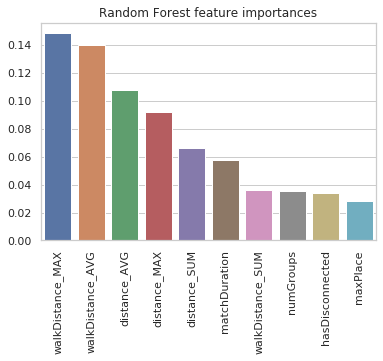

In [14]:
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(features_importances.nlargest(10).index, features_importances.nlargest(10).values)
ax.tick_params(axis='x', rotation=90)
plt.title("Random Forest feature importances")
plt.savefig('feature_importance_rf.pdf', bbox_inches='tight')
plt.show()

## Evaluation

In [15]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.20      0.30      4215
           2       0.74      0.81      0.77     42419
           3       0.66      0.64      0.65     42041
           4       0.71      0.72      0.71     44458
           5       0.82      0.83      0.82     43800
           6       0.78      0.54      0.64      4174

    accuracy                           0.73    181107
   macro avg       0.72      0.62      0.65    181107
weighted avg       0.73      0.73      0.73    181107



In [17]:
print(confusion_matrix(y_true, y_pred))

[[  839  3287    78     3     0     8]
 [  459 34184  7556   212     6     2]
 [   15  8784 26867  6213   155     7]
 [    0   203  6270 31818  6154    13]
 [    0     0    40  6626 36525   609]
 [    0     0     2     5  1912  2255]]


In [ ]:
spark.stop()